In [40]:
import obspy
import instaseis
import pymc as pm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from obspy.taup import TauPyModel
from mpl_toolkits.basemap import Basemap
from obspy.imaging.beachball import beach,beachball
from theano import shared
from pymc.Matplot import plot
import os

%matplotlib inline

### global CMT reported moment tensor for the August, 19, 2018 Fiji event
 PDEQ2018  8 19  0 19 38.00 -18.1800 -178.1100 563.4 0.0 8.2 FIJI ISLANDS REGION
 
event name:     201808190019A

time shift:     18.7900

half duration:  31.2000

latitude:      -17.7700

longitude:    -177.8000

depth:         558.5600

Mrr:      -1.530000e+28

Mtt:      -7.600001e+26

Mpp:       1.600000e+28

Mrt:      -4.010000e+27

Mrp:      -1.970000e+28

Mtp:       7.130000e+27

In [89]:
evla = -18.79
evlo = -177.80
evdp = 558.56
stlo = -163.42
stla = 54.86
mrr_true = -1.53e28 / 1.e7
mtt_true = -7.60e26 / 1.e7
mpp_true = 1.60e28 / 1.e7
mrt_true = -4.01e27 / 1.e7
mrp_true = -1.97e28 / 1.e7
mtp_true = 7.13e27 / 1.e7

### Read data for Fiji event data

/home/romaguir/Documents/europa_seismo/notebooks
BHE 53788.48937207874 294 2018-08-19T00:28:29.008200Z 2018-08-19T00:48:01.008200Z
BHN 21522.68379099863 294 2018-08-19T00:28:29.008200Z 2018-08-19T00:48:01.008200Z
BHZ 14319.937382774098 294 2018-08-19T00:28:29.008000Z 2018-08-19T00:48:01.008000Z


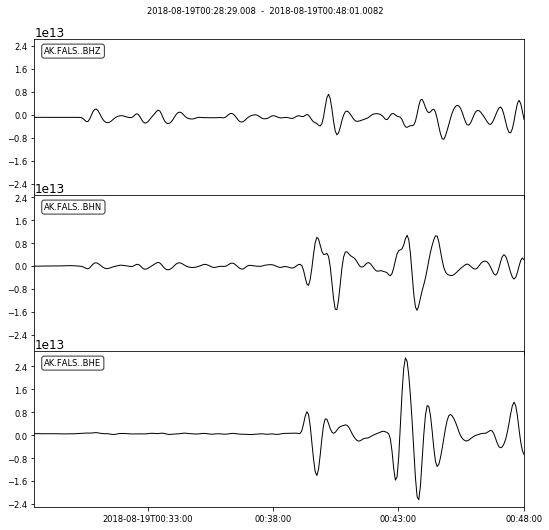

Text(0.5,1,'data vector')

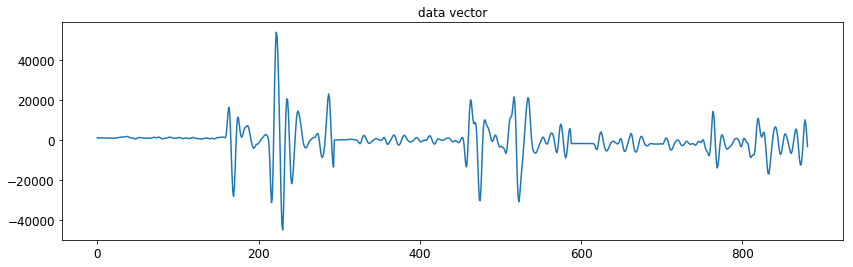

In [90]:
DIR = os.getcwd()
print DIR
st = obspy.read(DIR+'/../data/test_sac_data/AK*')
#st.detrend()
st.filter('lowpass',freq=1/50.0)
st.resample(0.25)
st_true = st.trim(starttime=obspy.UTCDateTime('2018-08-19T00:28:30.000000Z'),
                  endtime=obspy.UTCDateTime('2018-08-19T00:48:00.000000Z'))
for tr in st:
    print tr.stats.channel,np.max(tr.data),tr.stats.npts,tr.stats.starttime,tr.stats.endtime
st_true.plot()
data_true = np.hstack((st_true[0].data,st_true[1].data,st_true[2].data))
fig,ax=plt.subplots(1,figsize=[14,4])
ax.plot(data_true)
ax.set_title('data vector')

### Open instaseis database

In [91]:
db = instaseis.open_db("/home/romaguir/Documents/10s_PREM_ANI_FORCES/")
print db

ReciprocalInstaseisDB reciprocal Green's function Database (v7) generated with these parameters:
	components           : vertical and horizontal
	velocity model       : prem_ani
	attenuation          : True
	dominant period      : 10.000 s
	dump type            : displ_only
	excitation type      : dipole
	time step            : 2.436 s
	sampling rate        : 0.411 Hz
	number of samples    : 739
	seismogram length    : 1797.7 s
	source time function : errorf
	source shift         : 17.051 s
	spatial order        : 4
	min/max radius       : 5700.0 - 6371.0 km
	Planet radius        : 6371.0 km
	min/max distance     : 0.0 - 180.0 deg
	time stepping scheme : newmark2
	compiler/user        : gfortran 4.9.1 by lion on Laptop
	directory/url        : ../../10s_PREM_ANI_FORCES
	size of netCDF files : 3.4 GB
	generated by AxiSEM version 60945ec at 2014-10-23T21:32:58.000000Z



LXE 32554.00318178406 294 2018-08-19T00:28:29.008200Z 2018-08-19T00:48:01.008200Z
LXN 132505.2371610685 294 2018-08-19T00:28:29.008200Z 2018-08-19T00:48:01.008200Z
LXZ 60538.25609146443 294 2018-08-19T00:28:29.008200Z 2018-08-19T00:48:01.008200Z


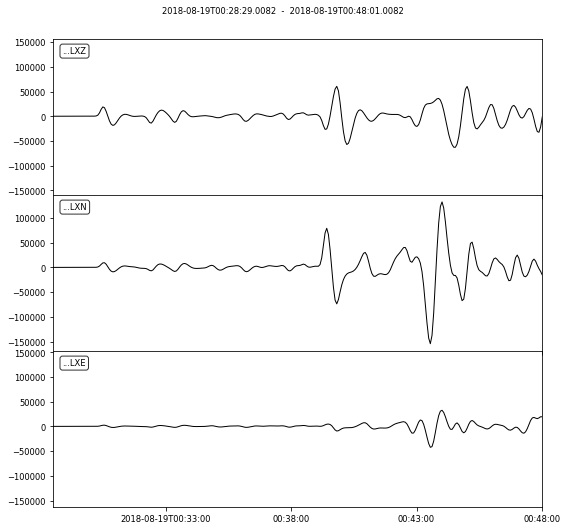

Text(0.5,1,'test data vector')

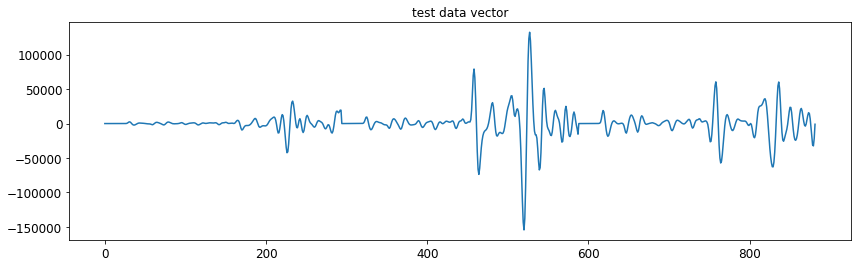

In [93]:
source = instaseis.Source(latitude=evla,
                          longitude=evlo,
                          depth_in_m=evdp*1000.0,
                          m_rr = 2.5e21,
                          m_pp = -2.5e21,
                          origin_time = obspy.UTCDateTime('2018-08-19T00:19:37.008200Z'))
receiver = instaseis.Receiver(latitude=stla,longitude=stlo)
st_test = db.get_seismograms(source=source,receiver=receiver,kind='velocity',components='ENZ')
st_test.filter('lowpass',freq=1/50.0)
st_test.resample(0.25)
st_test.trim(starttime=obspy.UTCDateTime('2018-08-19T00:28:30.000000Z'),
             endtime=obspy.UTCDateTime('2018-08-19T00:48:00.000000Z'))
for tr in st_test:
    tr.data *= 1e9
    print tr.stats.channel,np.max(tr.data),tr.stats.npts,tr.stats.starttime,tr.stats.endtime
st_test.plot()
data_vector = np.hstack((st_test[0].data,st_test[1].data,st_test[2].data))
fig=plt.figure(figsize=[14,4])
plt.plot(data_vector)
plt.title('test data vector')

### Define Monte Carlo model

In [116]:
#define stochastic variables
#m_rr = pm.Uniform('m_rr',lower=-1e22,upper=1e22)
#m_tt = pm.Uniform('m_tt',lower=-1e22,upper=1e22)
#m_pp = pm.Uniform('m_pp',lower=-1e22,upper=1e22)
#m_rt = pm.Uniform('m_rt',lower=-1e22,upper=1e22)
#m_rp = pm.Uniform('m_rp',lower=-1e22,upper=1e22)
#m_tp = pm.Uniform('m_tp',lower=-1e22,upper=1e22)
m_rr = pm.Uniform('m_rr',lower=-1000,upper=1000)
m_tt = pm.Uniform('m_tt',lower=-1000,upper=1000)
m_pp = pm.Uniform('m_pp',lower=-1000,upper=1000)
m_rt = pm.Uniform('m_rt',lower=-1000,upper=1000)
m_rp = pm.Uniform('m_rp',lower=-1000,upper=1000)
m_tp = pm.Uniform('m_tp',lower=-1000,upper=1000)
best_lat = pm.Uniform('best_lat',lower=evla-1.,upper=evla+1.)
best_lon = pm.Uniform('best_lon',lower=evlo-1.,upper=evlo+1.)
best_dep = pm.Uniform('best_dep',lower=evdp-10.,upper=evdp+10.)
mt = [m_rr,m_tt,m_pp,m_tp,m_rp,m_tp]

#define data variance
#sigma = 0.25 #THIS IS WHAT I FIRST USED
sigma = 0.05
tau = np.power(sigma,-2)

sample_rate = 0.25
scale_data = 1.e9
return_stream = False
scale_mt = 1e19

#define forward model
@pm.deterministic
def mu(m_rr=m_rr,m_tt=m_tt,m_pp=m_pp,m_rt=m_rt,m_rp=m_rp,m_tp=m_tp,
       best_lat=best_lat,best_lon=best_lon,best_dep=best_dep,scale_mt=scale_mt):
    
    source = instaseis.Source(
                       latitude=best_lat, 
                       longitude=best_lon, 
                       depth_in_m=best_dep*1000,
                       m_rr = m_rr*scale_mt,
                       m_tt = m_tt*scale_mt,
                       m_pp = m_pp*scale_mt,
                       m_rt = m_rt*scale_mt,
                       m_rp = m_rp*scale_mt,
                       m_tp = m_tp*scale_mt,
                       origin_time=obspy.UTCDateTime('2018-08-19T00:19:37.008200Z'))
    
    receiver = instaseis.Receiver(
               latitude=54.86, 
               longitude=-163.42, 
               network="TA", 
               station="FALS")
    
    st = db.get_seismograms(source=source, receiver=receiver,
                            components='ENZ',kind='velocity')
    st.filter('lowpass',freq=1/50.0)
    if sample_rate is not None:
        st.resample(sample_rate)
        
    st.trim(starttime=obspy.UTCDateTime('2018-08-19T00:28:30.000000Z'),
             endtime=obspy.UTCDateTime('2018-08-19T00:48:00.000000Z'))
    
    data_vector = np.hstack((st[0].data,st[1].data,st[2].data))
    data_vector *= scale_data

    if return_stream:
        return data_vector,st
    else:
        return data_vector

#define likelyhood
y = pm.Normal('y', mu=mu, tau=tau, value=data_true, observed=True)
#y = pm.Normal('y', mu=mu, tau=tau, value=data_true)

#inference
m = pm.Model([m_rr,m_tt,m_pp,m_rt,m_rp,m_tp,tau,y])
mc = pm.MCMC(m)
mc.sample(iter=400000,burn=50000)

 [-----------------100%-----------------] 400000 of 400000 complete in 40196.4 sec

### Plot results

Text(0.5,1,'m_tp')

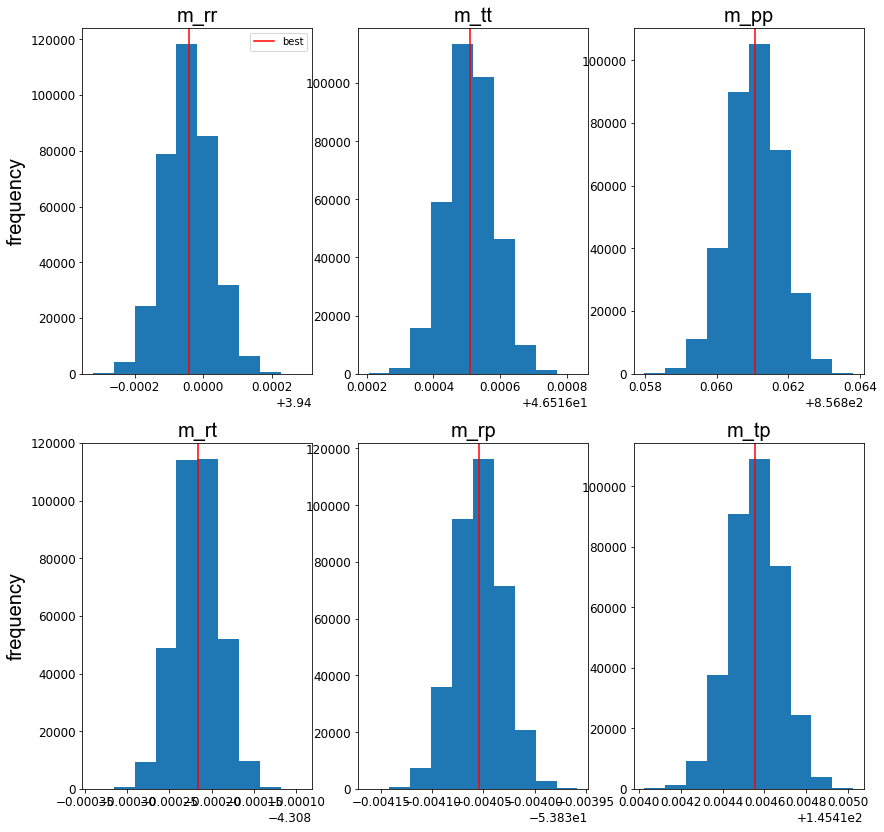

In [117]:
import matplotlib
from matplotlib.gridspec import GridSpec
matplotlib.rc('xtick', labelsize=12)     
matplotlib.rc('ytick', labelsize=12)
axis_font = {'fontname':'Arial', 'size':'20'}
fig = plt.figure(figsize=(14,14))
gs = GridSpec(2,3)

ax1 = plt.subplot(gs[0,0])
#ax1.axvline(mrr_true,c='k',label='true')
ax1.axvline(np.mean(m_rr.trace()),c='r',label='best')
ax1.hist(m_rr.trace())
ax1.set_title('m_rr',**axis_font)
ax1.set_ylabel('frequency',**axis_font)
ax1.legend()

ax2 = plt.subplot(gs[0,1])
#ax2.axvline(mtt_true,c='k')
ax2.axvline(np.mean(m_tt.trace()),c='r')
ax2.hist(m_tt.trace())
ax2.set_title('m_tt',**axis_font)

ax2 = plt.subplot(gs[0,2])
ax2.axvline(np.mean(m_pp.trace()),c='r')
#ax2.axvline(mpp_true,c='k')
ax2.hist(m_pp.trace())
ax2.set_title('m_pp',**axis_font)

ax4 = plt.subplot(gs[1,0])
#ax4.axvline(mrt_true,c='k')
ax4.axvline(np.mean(m_rt.trace()),c='r')
ax4.hist(m_rt.trace())
ax4.set_title('m_rt',**axis_font)
ax4.set_ylabel('frequency',**axis_font)

ax5 = plt.subplot(gs[1,1])
ax5.axvline(np.mean(m_rp.trace()),c='r')
#ax5.axvline(mrp_true,c='k')
ax5.hist(m_rp.trace())
ax5.set_title('m_rp',**axis_font)

ax6 = plt.subplot(gs[1,2])
ax6.axvline(np.mean(m_tp.trace()),c='r')
#ax6.axvline(mtp_true,c='k')
ax6.hist(m_tp.trace())
ax6.set_title('m_tp',**axis_font)

Text(0.5,1,'MCMC Mean MT')

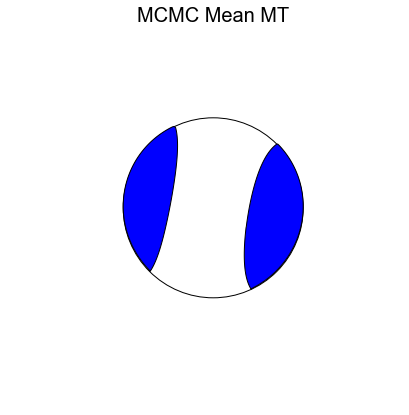

In [118]:
mt_mean = [np.mean(m_rr.trace()),np.mean(m_tt.trace()),
           np.mean(m_pp.trace()),np.mean(m_rt.trace()),
           np.mean(m_rp.trace()),np.mean(m_tp.trace())]
axis_font = {'fontname':'Arial', 'size':'20'}
fig=plt.figure(figsize=(10,10))
#ax1=fig.add_axes([-0.5,-0.5,0.5,0.5])
#b1 = beach(mt_true, xy=(0.5,0.5), width=0.5, linewidth=1, alpha=1.0)
#ax1.add_collection(b1)
#ax1.set_axis_off()
#ax1.set_title('True MT',**axis_font)
ax2=fig.add_axes([0.0,-0.5,0.5,0.5])
b2 = beach(mt_mean, xy=(0.5,0.5), width=0.5, linewidth=1, alpha=1.0)
ax2.add_collection(b2)
ax2.set_axis_off()
ax2.set_title('MCMC Mean MT',**axis_font)

Plotting best_lon
Plotting m_tt
Cannot plot autocorrelation for m_tt
Plotting m_rr
Cannot plot autocorrelation for m_rr
Plotting m_pp
Cannot plot autocorrelation for m_pp
Plotting m_rt
Plotting m_rp
Plotting m_tp
Plotting best_lat
Plotting best_dep


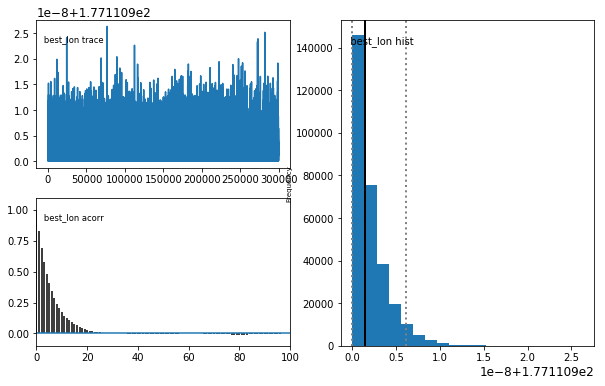

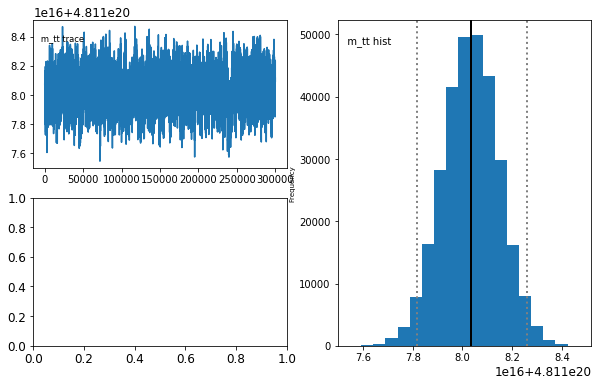

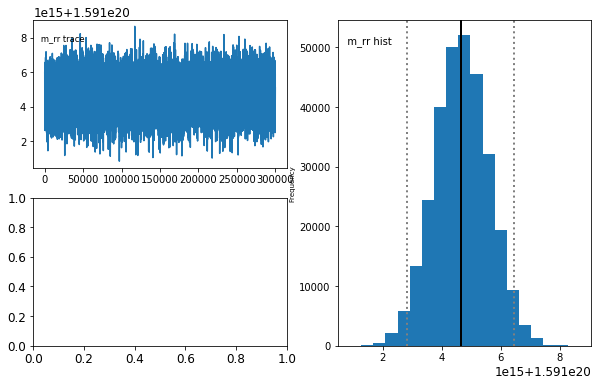

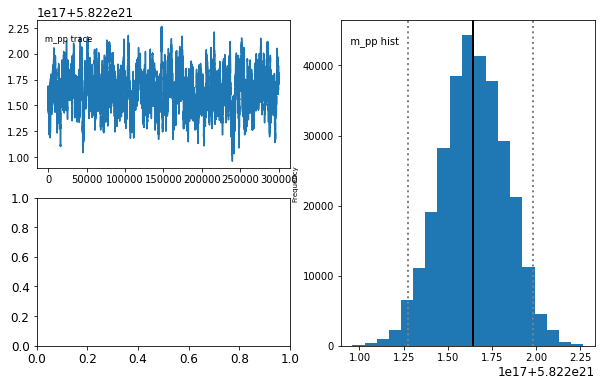

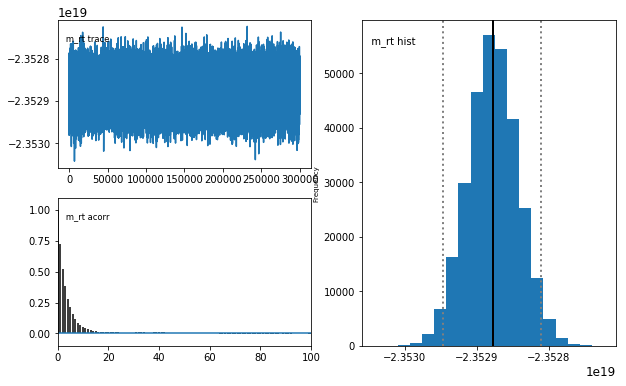

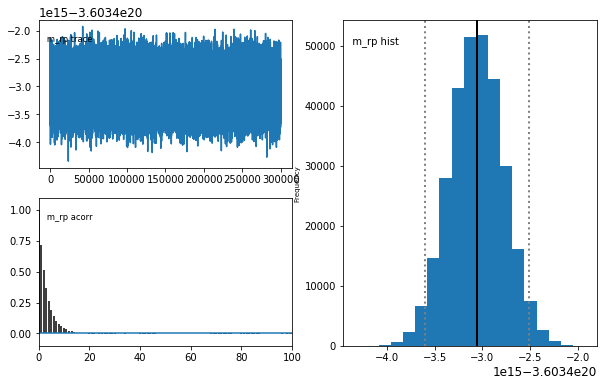

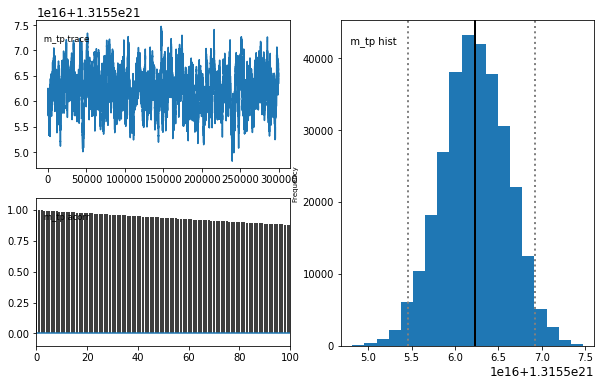

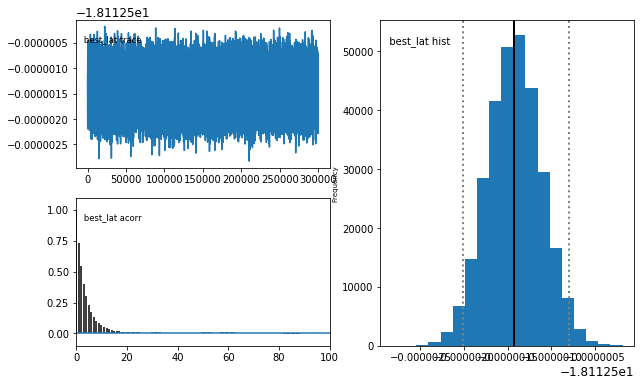

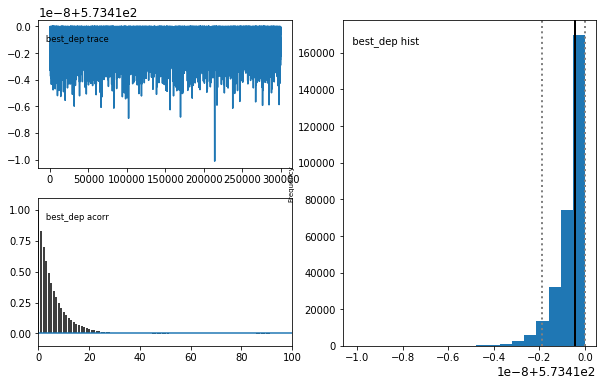

In [21]:
plot(mc)

In [22]:
mc.summary()


best_lon:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	177.111          0.0              0.0            [177.111 177.111]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	177.111          177.111         177.111        177.111       177.111
	

m_tt:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	4.8118033725053796e+201127195264944810.843276309695539.516[4.81178185e+20 4.81182586e+20]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	4.8117812512311267e+204.811795779967561e+204.8118034279113726e+204.811810998352706e+204.8118253227561425e+20
	

m_rr:
 
	Mean             SD   

LXE 31664.976123567947
LXN 15394.993589032947
LXZ 7568.831821583875


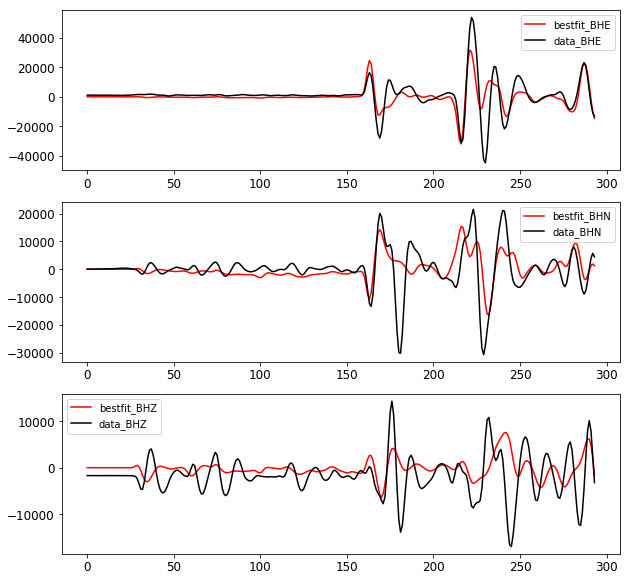

In [119]:
source = instaseis.Source(latitude=np.mean(best_lat.trace()),
                          longitude=np.mean(best_lon.trace()),
                          depth_in_m=np.mean(best_dep.trace())*1000.0,
                          m_rr = mt_mean[0]*scale_mt,
                          m_tt = mt_mean[1]*scale_mt,
                          m_pp = mt_mean[2]*scale_mt,
                          m_rt = mt_mean[3]*scale_mt,
                          m_rp = mt_mean[4]*scale_mt,
                          m_tp = mt_mean[5]*scale_mt,
                          #m_rr=mrr_true,
                          #m_tt=mtt_true,
                          #m_pp=mpp_true,
                          #m_rt=mrt_true,
                          #m_rp=mrp_true,
                          #_tp=mtp_true,
                          origin_time = obspy.UTCDateTime('2018-08-19T00:19:37.008200Z'))
receiver = instaseis.Receiver(latitude=stla,longitude=stlo)
st_best = db.get_seismograms(source=source,receiver=receiver,kind='velocity',components='ENZ')
st_best.filter('lowpass',freq=1/50.)
st_best.resample(0.25)
for tr in st_best:
    tr.data *= 1e9
    print tr.stats.channel,np.max(tr.data)
st_best.trim(starttime=obspy.UTCDateTime('2018-08-19T00:28:30.000000Z'),
             endtime=obspy.UTCDateTime('2018-08-19T00:48:00.000000Z'))
fig,axes = plt.subplots(3,figsize=[10,10])
axes[0].plot(st_best[0].data,c='r',label='bestfit_{}'.format(st[0].stats.channel))
axes[0].plot(st_true[0].data,c='k',label='data_{}'.format(st[0].stats.channel))
axes[1].plot(st_best[1].data,c='r',label='bestfit_{}'.format(st[1].stats.channel))
axes[1].plot(st_true[1].data,c='k',label='data_{}'.format(st[1].stats.channel))
axes[2].plot(st_best[2].data,c='r',label='bestfit_{}'.format(st[2].stats.channel))
axes[2].plot(st_true[2].data,c='k',label='data_{}'.format(st[2].stats.channel))
axes[0].legend()
axes[1].legend()
axes[2].legend()

### Actual CMT solution

-1.53e+21 -7.600001e+19


In [104]:
print CMTMrr,CMTMtt,CMTMpp,CMTMrt,CMTMrp,CMTMtp
print mt_mean[0],mt_mean[1],mt_mean[2],mt_mean[3],mt_mean[4],mt_mean[5]
mt_true = [CMTMrr,CMTMtt,CMTMpp,CMTMrt,CMTMrp,CMTMtp]

-1.53e+21 -7.600001e+19 1.6e+21 -4.01e+20 -1.97e+21 7.13e+20
9.20153970133e+20 5.03062610818e+20 3.42625972107e+21 2.88541660818e+19 -5.87232280498e+19 5.94351384477e+20


In [82]:
print np.mean(best_dep.trace())
print np.mean(best_lon.trace())
print np.mean(best_lat.trace())

573.4099999987733
177.11090000000675
-19.177699999998698
